# 2.10 Dual basis functions
We use dual basis functions to define interpolation operators, define transfer operators between different finite element spaces, and auxiliary space preconditioners.

### Canonical interpolation
The canonical finite element interpolation operator is defined by specifying the degrees of freedom. For low order methods these are typically nodal values, while for high order methods these are most often moments. For example, the interpolation of a function $u$ onto the $p^{th}$ order triangle is given by: find $u_{hp} \in V_{hp}$ such that

\begin{eqnarray*}
u_{hp} (V) & = & u(V) \quad \forall \text{ vertices } V \\
\int_E u_{hp} q & = & \int_E u q \quad \forall q \in P^{p-2}(E) \; \forall \text{ edges } E \\
\int_T u_{hp} q & = & \int_T u q \quad \forall q \in P^{p-3}(T) \; \forall \text{ triangles } T
\end{eqnarray*}


In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

import matplotlib.pylab as plt
mesh = Mesh(unit_square.GenerateMesh(maxh=2))

The NGSolve 'Set' function does local projection, and simple averaging. In particular, this does not respect point values in mesh vertices. 

In [2]:
fes = H1(mesh, order=3, low_order_space=False)  

func = x*x*x*x
gfu = GridFunction(fes)
gfu.Set(func)
Draw (gfu)
print (gfu.vec)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 -0.0223792
 0.991843
 0.977621
 -0.00815655
 3.34984
 2.19912
 3.34984
       2
 0.00660131
 7.68122e-15
 0.00660131
 1.42109e-14
 3.34984
 -1.80088
 -2.17601
 1.82399




Most NGSolve finite element spaces provide now a "dual" operator, which delivers the moments (i.e. the dual space basis functions) instead of function values. The integrals over faces, edges and also vertices are defined by co-dimension 1 (=BND), co-dimension 2 (=BBND) or co-dimension 3 (=BBBND) integrals over the volume elements.
We define a variational problem for canonical interpolation:

In [3]:
u,v = fes.TnT()
vdual = v.Operator("dual")

a = BilinearForm(fes)
a += u*vdual*dx + u*vdual*dx(element_vb=BND) + \
    u*vdual*dx(element_vb=BBND)
a.Assemble()

f = LinearForm(fes)
f += func*vdual*dx + func*vdual*dx(element_vb=BND) + \
    func*vdual*dx(element_vb=BBND)
f.Assemble()

# interpolation in vertices preserves values 0 and 1
gfu.vec.data = a.mat.Inverse() * f.vec
print (gfu.vec)
Draw (gfu);

       0
       1
       1
       0
     3.6
       2
     3.6
       2
       0
       0
 6.66134e-16
 -1.66533e-15
     3.6
      -2
      -2
       2




WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

The vertex degrees of freedom vanish for edge and element basis functions, and the edge degrees of freedom vanish for element basis functions, but not vice-versa. Thus, the obtained matrix A is block-triangular:

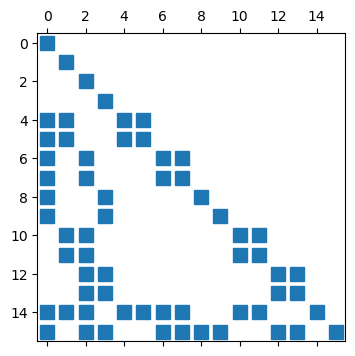

In [4]:
import scipy.sparse as sp
A = sp.csr_matrix(a.mat.CSR())
plt.rcParams['figure.figsize'] = (4,4)
plt.spy(A)
plt.show()

We can use proper block Gauss-Seidel smoothing for solving with that block triangular matrix by blocking the dofs for the individual vertices, edges and elements. Since the NGSolve Gauss-Seidel smoother reorders the order of smoothing blocks for parallelization, we have to take care to first compute vertex values, then edge values, and finally element values by running three different Gauss-Seidel sweeps.

In [5]:
vblocks = [fes.GetDofNrs(vertex) for vertex in mesh.vertices]
eblocks = [fes.GetDofNrs(edge) for edge in mesh.edges]
fblocks = [fes.GetDofNrs(face) for face in mesh.faces]

print (vblocks)
print (eblocks)
print (fblocks)

vinv = a.mat.CreateBlockSmoother(vblocks)
einv = a.mat.CreateBlockSmoother(eblocks)
finv = a.mat.CreateBlockSmoother(fblocks)

vinv.Smooth(gfu.vec, f.vec)
einv.Smooth(gfu.vec, f.vec)
finv.Smooth(gfu.vec, f.vec)
print (gfu.vec)

[(0,), (1,), (2,), (3,)]
[(4, 5), (6, 7), (8, 9), (10, 11), (12, 13)]
[(14,), (15,)]
       0
       1
       1
       0
     3.6
       2
     3.6
       2
       0
       0
 6.66134e-16
 -1.66533e-15
     3.6
      -2
      -2
       2




## Embedding Finite Element Spaces
This interpolation can be used to transform functions from one finite element space $V_{src}$ to another one $V_{dst}$. We use the dual space of the destination space:

$$
\int_{node} u_{dst} v_{dual} = \int_{node} u_{src} v_{dual} \qquad
\forall \, v_{dual} \; \forall \, \text{nodes}
$$

The left hand side leads to a non-symmetric square matrix, the right hand side to a rectangular matrix.

As an example we implement the transformation from an vector valued $H^1$ space into $H(\operatorname{div})$:

In [6]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))

fesh1 = VectorH1(mesh, order=2)
feshdiv = HDiv(mesh, order=2)

gfuh1 = GridFunction(fesh1)
gfuh1.Set ( (x*x,y*y) )

gfuhdiv = GridFunction(feshdiv, name="uhdiv")

Build the matrices, and use a direct solver:

In [7]:
amixed = BilinearForm(trialspace=fesh1, testspace=feshdiv)
ahdiv = BilinearForm(feshdiv)

u,v = feshdiv.TnT()
vdual = v.Operator("dual")
uh1 = fesh1.TrialFunction()

dS = dx(element_boundary=True)
ahdiv += u*vdual * dx + u*vdual * dS
ahdiv.Assemble()

amixed += uh1*vdual*dx + uh1*vdual*dS
amixed.Assemble()

# build transformation operator:
transform = ahdiv.mat.Inverse() @ amixed.mat
gfuhdiv.vec.data = transform * gfuh1.vec

Draw (gfuh1)
Draw (gfuhdiv)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

We implement a linear operator performing the fast conversion by Gauss-Seidel smoothing: 

In [8]:
class MyBlockInverse(BaseMatrix):
    def __init__ (self, mat, eblocks, fblocks):
        super(MyBlockInverse, self).__init__()
        self.mat = mat
        self.einv = mat.CreateBlockSmoother(eblocks)
        self.finv = mat.CreateBlockSmoother(fblocks)
        self.res = self.mat.CreateColVector()

    def CreateRowVector(self):
        return self.mat.CreateColVector()
    def CreateColVector(self):
        return self.mat.CreateRowVector()
        
    def Mult(self, x, y):
        # y[:] = 0
        # self.einv.Smooth(y,x)    #   y = y +  A_E^-1  (x - A y)
        # self.finv.Smooth(y,x)    #   y = y +  A_E^-1  (x - A y)
        
        # the same, but we see how to transpose that
        y.data = self.einv * x
        self.res.data = x - self.mat * y
        y.data += finv * self.res

    def MultTrans(self, x, y):
        y.data = self.finv.T * x
        self.res.data = x - self.mat.T * y
        y.data += einv.T * self.res


eblocks = [feshdiv.GetDofNrs(edge) for edge in mesh.edges]
fblocks = [feshdiv.GetDofNrs(face) for face in mesh.faces]

transform = MyBlockInverse(ahdiv.mat, eblocks, fblocks) @ amixed.mat
gfuhdiv.vec.data = transform * gfuh1.vec

## Auxiliary Space Preconditioning
Nepomnyaschikh 91, Hiptmair-Xu 07, ....

Assume we have a complicated problem with some complicated discretization, and we have good preconditioners for a nodal finite element discretization for the Laplace operator. By auxiliary space preconditioning we can reuse the simple preconditioners for the complicated problems. It is simple, and works well in many cases.

As a simple example, we precondition a DG discretization by an $H^1$ conforming method. 

In [9]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

The DG discretization:

In [10]:
order=4
fesDG = L2(mesh, order=order, dgjumps=True)
u,v = fesDG.TnT()
aDG = BilinearForm(fesDG)
jump_u = u-u.Other()
jump_v = v-v.Other()
n = specialcf.normal(2)
mean_dudn = 0.5*n * (grad(u)+grad(u.Other()))
mean_dvdn = 0.5*n * (grad(v)+grad(v.Other()))
alpha = 4
h = specialcf.mesh_size
aDG = BilinearForm(fesDG)
aDG += grad(u)*grad(v) * dx
aDG += alpha*order**2/h*jump_u*jump_v * dx(skeleton=True)
aDG += alpha*order**2/h*u*v * ds(skeleton=True)
aDG += (-mean_dudn*jump_v -mean_dvdn*jump_u) * dx(skeleton=True)
aDG += (-n*grad(u)*v-n*grad(v)*u)* ds(skeleton=True)
aDG.Assemble()

fDG = LinearForm(fesDG)
fDG += 1*v * dx
fDG.Assemble()
gfuDG = GridFunction(fesDG)

The auxiliary $H^1$ discretization:

In [11]:
fesH1 = H1(mesh, order=2, dirichlet=".*")
u,v = fesH1.TnT()
aH1 = BilinearForm(fesH1)
aH1 += grad(u)*grad(v)*dx
preH1 = Preconditioner(aH1, "bddc")
aH1.Assemble()

In [12]:
transform = fesH1.ConvertL2Operator(fesDG)
pre = transform @ preH1.mat @ transform.T + aDG.mat.CreateSmoother()

solvers.CG(mat=aDG.mat, rhs=fDG.vec, sol=gfuDG.vec, pre=pre, \
           maxsteps=200)

Draw (gfuDG)

CG iteration 1, residual = 0.25321197332192374     
CG iteration 2, residual = 0.03283242148303799     
CG iteration 3, residual = 0.008130862525680996     
CG iteration 4, residual = 0.003434248811060353     
CG iteration 5, residual = 0.0011783456811530655     
CG iteration 6, residual = 0.0009046659695335943     
CG iteration 7, residual = 0.0009161002088522357     
CG iteration 8, residual = 0.0010697558880604981     
CG iteration 9, residual = 0.0007971399933259832     
CG iteration 10, residual = 0.0006627896366674873     
CG iteration 11, residual = 0.0005095344857659243     
CG iteration 12, residual = 0.0004246644493713774     
CG iteration 13, residual = 0.0003261702302927913     
CG iteration 14, residual = 0.0003439552949808797     
CG iteration 15, residual = 0.0002710525126777647     
CG iteration 16, residual = 0.00023336881656180276     
CG iteration 17, residual = 0.00017983771681640928     
CG iteration 18, residual = 0.0001356676383204533     
CG iteration 19, residu

CG iteration 109, residual = 2.981063991673226e-11     
CG iteration 110, residual = 2.5236152799221824e-11     
CG iteration 111, residual = 2.3858924738721057e-11     
CG iteration 112, residual = 2.2840110226172454e-11     
CG iteration 113, residual = 2.003341922092308e-11     
CG iteration 114, residual = 1.5400083217621838e-11     
CG iteration 115, residual = 1.2129300498104331e-11     
CG iteration 116, residual = 1.0191622151281582e-11     
CG iteration 117, residual = 9.955251183472822e-12     
CG iteration 118, residual = 9.131990787888884e-12     
CG iteration 119, residual = 8.359467885340022e-12     
CG iteration 120, residual = 6.910324008285709e-12     
CG iteration 121, residual = 5.383911691428594e-12     
CG iteration 122, residual = 4.235570032438656e-12     
CG iteration 123, residual = 3.8609264052107606e-12     
CG iteration 124, residual = 3.631885373535994e-12     
CG iteration 125, residual = 3.070757123157699e-12     
CG iteration 126, residual = 2.4629141842

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene